In [12]:
import pandas as pd
import numpy as np
import json
from ladybug.epw import EPW
from lightning.pytorch import Trainer
from pathlib import Path

from ml.surrogate import Surrogate
from ml.predict import predict_ubem
from weather.weather import extract
from utils.constants import *

In [37]:
registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v3"
resource = "model.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)
surrogate.model.eval()

trainer = Trainer(
        accelerator="auto",
        devices="auto",
        strategy="auto",
        enable_progress_bar=True,
    )

c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'target_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['target_transform'])`.
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'weather_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['weather_transform'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


### Iteration settings

In [31]:
# Get grasshopper json data for config
data_dir = "D:/DATA/AutozonerTests"
name = "test"

settings_dir = Path(data_dir) / f"{name}_settings.json"
results_dir = Path(data_dir) / f"{name}_CSresults.json"
# settings_dict_dir = "D:/DATA/SingleShoeboxTests/Shoebox_sched3.json"
with open(settings_dir, 'r') as f:
    settings_dict = json.load(f)

In [23]:
# epw = EPW("/teamspace/uploads/USA_NY_New.York-LaGuardia.AP.725030_TMYx.2004-2018.epw")
# epw = EPW("C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_CA_Los.Angeles.Intl.AP.722950_TMYx.2004-2018.epw")
# epw = EPW("C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2004-2018.epw")
epw = EPW("C:/ProgramData/Solemma/Common/WeatherData/EPW/USA_NY_New.York-LaGuardia.AP.725030_TMYx.2004-2018.epw")
# epw = EPW("/teamspace/uploads/USA_CA_Los.Angeles.Intl.AP.722950_TMYx.2004-2018.epw")
# epw = EPW("/teamspace/uploads/USA_MA_Boston-Logan.Intl.AP.725090_TMYx.2004-2018.epw")
climate = extract(epw)

In [32]:
blds_settings = settings_dict["BuildingSettings"]
config = settings_dict["ShoeboxConfig"].copy()

In [46]:
"""
Make Schedules
"""
all_schedules = pd.read_hdf("data/schedules.h5")
idx = blds_settings["schedule_index"]
print(idx)
schedules = np.reshape(all_schedules.loc[all_schedules.index[idx*3][0]].to_numpy(), (1,3,8760))
schedules.shape

5


(1, 3, 8760)

In [28]:
def get_tmas_idx(val):
    if val >= ThermalMassCapacities.Concrete:
        hot_bin = ThermalMassConstructions.Concrete.value
    elif (
        val < ThermalMassCapacities.Concrete and val >= ThermalMassCapacities.Brick
    ):
        hot_bin = ThermalMassConstructions.Brick.value
    elif (
        val < ThermalMassCapacities.Brick and val >= ThermalMassCapacities.WoodFrame
    ):
        hot_bin = ThermalMassConstructions.WoodFrame.value
    elif val < ThermalMassCapacities.WoodFrame:
        hot_bin = ThermalMassConstructions.SteelFrame.value
    return hot_bin

In [42]:
if settings_dict["Conditioning"]["HeatRecoveryType"] == "None":
    hrv = 0
else:
    hrv = HRV[settings_dict["Conditioning"]["HeatRecoveryType"]].value 
if "occ" in settings_dict["Conditioning"]["MechVentSchedule"].lower():
    vent_mode = 2
else:
    vent_mode = 0

config.update({
    "FacadeMass": get_tmas_idx(float(settings_dict["ShoeboxConfig"]["RoofMass"])), 
    "RoofMass": get_tmas_idx(float(settings_dict["ShoeboxConfig"]["FacadeMass"])),
    "PeopleDensity": float(settings_dict["Loads"]["PeopleDensity"]),
    "EquipmentPowerDensity": float(settings_dict["Loads"]["EquipmentPowerDensity"]),
    "LightingPowerDensity": float(settings_dict["Loads"]["LightingPowerDensity"]),
    "HeatingSetpoint": float(settings_dict["Conditioning"]["HeatingSetpoint"]),
    "CoolingSetpoint": float(settings_dict["Conditioning"]["CoolingSetpoint"]),
    "cop_heating": 1,
    "cop_cooling": 1,
    "VentilationMode": vent_mode, 
    "VentilationPerArea": float(settings_dict["Conditioning"]["MinFreshAirArea"]/1000),
    "VentilationPerPerson": float(settings_dict["Conditioning"]["MinFreshAirPerson"]/1000),
    "EconomizerSettings": Econ[settings_dict["Conditioning"]["EconomizerType"]].value,
    "RecoverySettings": hrv,
    "Infiltration": float(settings_dict["Infiltration"]["InfiltrationFlowPerExteriorSurfaceArea"]), #/1000
    "wwr": float(settings_dict["ShoeboxConfig"]["wwr"]),
    "building_id": 0,
    "weight": 1,
    "template_idx": 0.0,
})

for i in range(12):
    config[f"shading_{i}"] = 0

In [43]:
blds_settings

{'x_dim': 40.0,
 'y_dim': 40.0,
 'n_floors': 3.0,
 'schedule_index': 5,
 'f2f_height': 4.0}

In [47]:
features = pd.DataFrame(data=config, index=[0])
features = pd.concat([features]*12,axis=0)
features["roof_2_footprint"] = [0,0,1]*4
features["ground_2_footprint"] = [1,0,0]*4
# features["roof_2_footprint"] = [0.25]*12
# features["ground_2_footprint"] = [0.25]*12
features["orientation"] = [*[0]*3,*[np.pi/2]*3,*[np.pi]*3,*[3*np.pi/2]*3]

features.index = range(12)
for i in range(4):
    for j in range(3):
        features.loc[i*3+j,"name"] = f"{['bottom','middle','top'][j]}_{['south','east','north','west'][i]}"
shoebox_results, *_ = predict_ubem(trainer=trainer, surrogate=surrogate, features=features,schedules=schedules, climate=climate,apply_cops=False, batch_size=32,)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

c:\Users\zoelh\AppData\Local\anaconda3\envs\ml-for-bem\lib\site-packages\torch\nn\modules\conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1009.)
  return F.conv1d(input, weight, bias, self.stride,


Predicting: |          | 1/? [00:00<00:00,  5.13it/s]


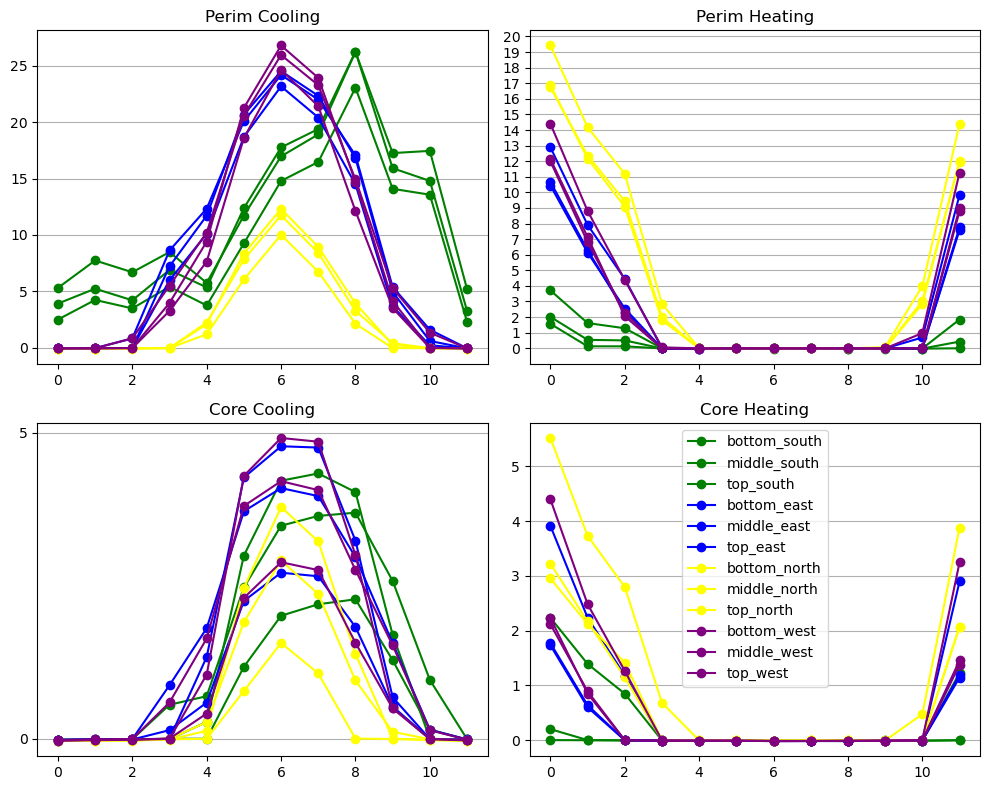

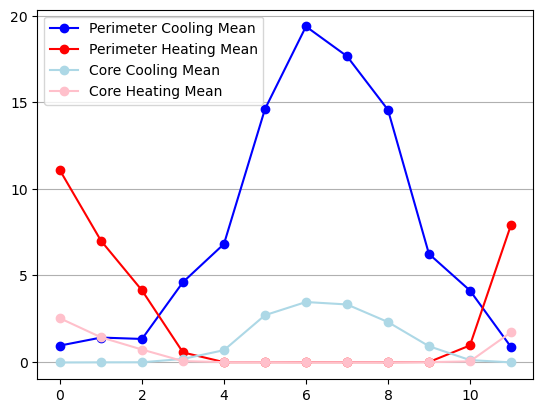

In [48]:
# shoebox_results = shoebox_results.set_index("box_name")
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

colors = {
    "bottom_south":"green",
    "middle_south": "green",
    "top_south": "green",
    "bottom_east":"blue",
    "middle_east": "blue",
    "top_east": "blue",
    "bottom_north":"yellow",
    "middle_north": "yellow",
    "top_north": "yellow",
    "bottom_west":"purple",
    "middle_west": "purple",
    "top_west": "purple",
}
fig,axs = plt.subplots(2,2,figsize=(10,8))
axs = [axs[0,0],axs[0,1],axs[1,0],axs[1,1]]

for i in range(12):
    axs[0].plot(shoebox_results["Perimeter"]["Cooling"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])
    axs[1].plot(shoebox_results["Perimeter"]["Heating"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])
    axs[2].plot(shoebox_results["Core"]["Cooling"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])
    axs[3].plot(shoebox_results["Core"]["Heating"].values[i],"-o",label=features.loc[i,"name"],c=colors[features.loc[i,"name"]])


# axs[0].set_ylim([0,80])
# axs[1].set_ylim([0,5])
axs[0].yaxis.set_major_locator(MultipleLocator(5))
axs[1].yaxis.set_major_locator(MultipleLocator(1))
axs[2].yaxis.set_major_locator(MultipleLocator(5))
axs[3].yaxis.set_major_locator(MultipleLocator(1))

axs[0].grid(axis="y",which="major")
axs[1].grid(axis="y",which="major")
axs[2].grid(axis="y",which="major")
axs[3].grid(axis="y",which="major")

axs[0].set_title("Perim Cooling")
axs[1].set_title("Perim Heating")
axs[2].set_title("Core Cooling")
axs[3].set_title("Core Heating")
plt.legend()
fig.tight_layout()

fig = plt.figure()
plt.plot(shoebox_results["Perimeter"]["Cooling"].mean(axis=0).values,"-o",color="blue",label="Perimeter Cooling Mean")
plt.plot(shoebox_results["Perimeter"]["Heating"].mean(axis=0).values,"-o",color="red",label="Perimeter Heating Mean")
plt.plot(shoebox_results["Core"]["Cooling"].mean(axis=0).values,"-o",color="lightblue",label="Core Cooling Mean",)
plt.plot(shoebox_results["Core"]["Heating"].mean(axis=0).values,"-o",color="pink",label="Core Heating Mean",)
plt.gca().yaxis.set_major_locator(MultipleLocator(5))
plt.legend()
plt.grid(axis="y",which="major")

### Get CS results

In [85]:
with open(results_dir, 'r') as f:
    gh_results_data = json.load(f)
gh_results_data = {(outerKey, innerKey): values for outerKey, innerDict in gh_results_data.items() for innerKey, values in innerDict.items()}
gh_results_data = {outerKey + (innerKey,): values for outerKey, innerDict in gh_results_data.items() for innerKey, values in innerDict.items()}
gh_results = pd.DataFrame.from_dict(gh_results_data)


In [86]:
gh_results

CSshoeboxer                                 Autozoner                       \
       Cooling              Heating              Cooling              Heating   
          Core  Perimeter      Core  Perimeter      Core  Perimeter      Core   
0     0.000000   1.054948  1.703507  13.974754  0.000000   0.354981  1.673460   
1     0.000000   1.294965  0.849246   8.886686  0.000000   0.501879  1.010910   
2     0.000000   1.299750  0.495599   6.612002  0.000000   0.322583  0.597893   
3     0.028724   2.895866  0.040005   1.240676  0.026438   1.801030  0.073325   
4     0.440042   5.656253  0.000000   0.011197  0.372441   4.702527  0.000000   
5     2.084027  12.001422  0.000000   0.000000  1.826399  10.979220  0.000000   
6     3.140636  16.839430  0.000000   0.000000  2.743867  15.643620  0.000000   
7     2.719046  14.639725  0.000000   0.000000  2.389093  13.561639  0.000000   
8     1.731480  10.973739  0.000000   0.000000  1.556458   9.977817  0.000000   
9     0.119475   3.848925  0.000000   0.040378  0.184204   3.181652  0.000000   
10    0.001903   2.541938  0.020533   1.445004  0.061346   2.217786  0.120944   
11    0.000000   0.845998  1.079818  10.061963  0.000107   0.445524  1.141121   

               
               
    Perimeter  
0   11.857067  
1    7.249470  
2    5.018839  
3    0.854288  
4    0.012970  
5    0.000000  
6    0.000000  
7    0.000000  
8    0.000000  
9    0.037112  
10   1.435980  
11   8.469415

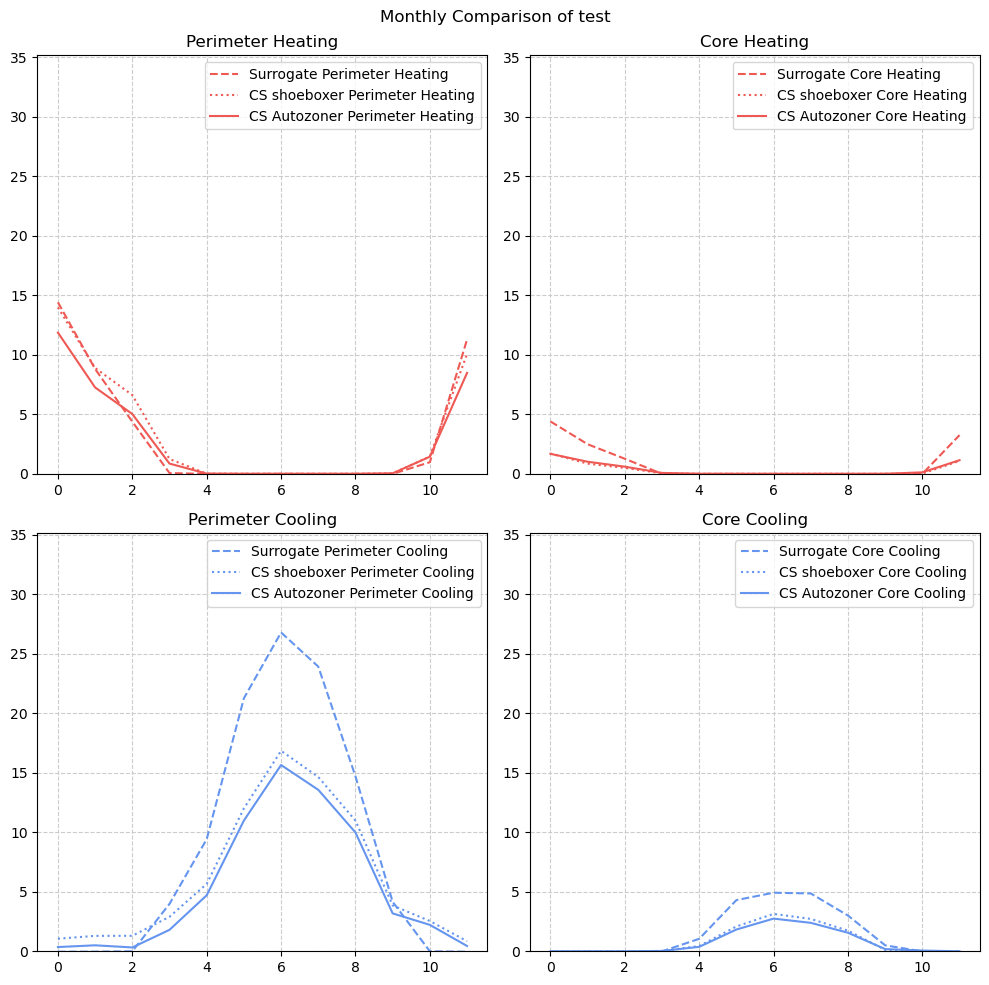

In [87]:
ix = -1
fig, axs = plt.subplots(2,2, figsize=(10,10))

for col, zone in [(0,"Perimeter"), (1,"Core")]:
    for row, end_use, color in [(0, "Heating", "#ef5954"),( 1, "Cooling", "#6595ef" )]:
        axs[row,col].set_title(f"{zone} {end_use}")
        axs[row,col].plot(shoebox_results[zone][end_use].values[ix], "--", label=f"Surrogate {zone} {end_use}", color=color)
        axs[row,col].plot(gh_results.CSshoeboxer[end_use][zone], ":", label=f"CS shoeboxer {zone} {end_use}", color=color)
        axs[row,col].plot(gh_results.Autozoner[end_use][zone], label=f"CS Autozoner {zone} {end_use}", color=color)
        # legend
        axs[row,col].legend()
fig.tight_layout()

absolute_max = max(axs[0, 0].get_ylim()[1], axs[1, 0].get_ylim()[1])
grid_size = 5
while absolute_max / grid_size > 20:
    grid_size += 5 
for i in range(2):
    axs[0, i].yaxis.set_major_locator(MultipleLocator(grid_size))
    axs[0, i].grid(which='major', color='#CCCCCC', linestyle='--')
    axs[1, i].yaxis.set_major_locator(MultipleLocator(grid_size))
    axs[1, i].grid(which='major', color='#CCCCCC', linestyle='--')
    axs[0, i].set_ylim([0,1.25*absolute_max])
    axs[1, i].set_ylim([0,1.25*absolute_max])
plt.legend()
plt.suptitle(f"Monthly Comparison of {name}")
fig.tight_layout()